## Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q timm kaggle efficientnet_pytorch albumentations==0.4.6 wldhx.yadisk-direct
!pip install wandb -qqq

     |████████████████████████████████| 431 kB 5.3 MB/s 
     |████████████████████████████████| 117 kB 48.1 MB/s 
     |████████████████████████████████| 948 kB 52.4 MB/s 
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 181 kB 38.3 MB/s 
     |████████████████████████████████| 145 kB 38.9 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 


In [ ]:
import gdown
import torch
import os
import sys
import yaml
import random
import argparse
import os.path as osp
import numpy as np
from tqdm import tqdm
import zipfile
import timm
import wandb

import torchvision as tv
import pandas as pd
import cv2
from PIL import Image
import torch.utils.data as data
from torch import nn
from torchvision import models # 

import torchvision.models as models # 
from sklearn.preprocessing import normalize
from sklearn import preprocessing

from collections import namedtuple
from collections import OrderedDict

from torch.nn import functional as F
from efficientnet_pytorch import EfficientNet

In [ ]:
!unzip /content/drive/MyDrive/Olimpiads/Machines_Can_See/MCS2022.Baseline-main.zip
# url = "https://drive.google.com/open?id=18EunmjOJsbE5Lh9zA0cZ4wKV6Um46dkg"
# gdown.download_folder(url, quiet=True, use_cookies=False)

In [ ]:
!yadisk-direct https://disk.yandex.ru/d/XkTgd7tSg6zElA
!curl -L $(yadisk-direct https://disk.yandex.ru/d/XkTgd7tSg6zElA) -o new_data.zip
!unzip /content/new_data.zip 

https://downloader.disk.yandex.ru/disk/ad97ae98258f972c9f8fb2924552e6486fa221c0377b7dd3e090f4d488ef9f9b/62a332da/_Bln1SvgVaexYGcUJVwX7lZZMYlwkLSoWEs2KSqPZ4XWsRqpQuyRoGyv_mCzll0xd33mWJ8YnGZohNOJSuEW6Q%3D%3D?uid=0&filename=data.zip&disposition=attachment&hash=x1wGyo11zxZRBkd71xuZ4RbrkZhI/P14ybFd/bA3zJTs6BZ2bRcm96qLDFTaTJk8q/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=389240466&fsize=16535798212&hid=c762eabde12280836e4b5d27b7ae51ce&media_type=compressed&tknv=v2
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
 38 15.4G   38 6119M    0     0  10.3M      0  0:25:24  0:09:51  0:15:33 10.5M^C
Archive:  /content/new_data.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latt

In [ ]:
!pip install -q kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json /content/kaggle.json

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
# !kaggle datasets download -d renancostaalencar/compcars
# !unzip -q compcars.zip
# !rm -rf compcars.zip

In [ ]:
!kaggle competitions download -c vehicle

100% 6.88G/6.88G [01:05<00:00, 136MB/s]
100% 6.88G/6.88G [01:05<00:00, 113MB/s]


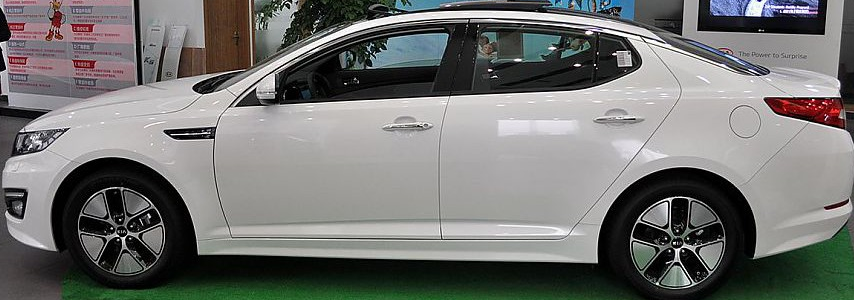

In [ ]:
def read_image(image_file):
    img = cv2.imread(image_file, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is None:
        raise ValueError('Failed to read {}'.format(image_file))
    # img = Image.fromarray(img.astype('uint8'), 'RGB')
    return img

imgf = read_image(os.path.join('image', tr['img_path'].loc[0]))
x1,	y1,	x2,	y2 = tr[tr.columns.tolist()[1:-1]].loc[0]
imgf = imgf[int(y1): int(y2), int(x1): int(x2)]


Image.fromarray(imgf.astype('uint8'), 'RGB')

## Utils.py

In [ ]:
def convert_dict_to_tuple(dictionary):
    for key, value in dictionary.items():
        if isinstance(value, dict):
            dictionary[key] = convert_dict_to_tuple(value)
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)


def save_checkpoint(model, optimizer, scheduler, epoch, outdir):
    """Saves checkpoint to disk"""
    filename = "model_{:04d}.pth".format(epoch)
    directory = outdir
    filename = os.path.join(directory, filename)
    weights = model.state_dict()
    state = OrderedDict([
        ('state_dict', weights),
        ('optimizer', optimizer.state_dict()),
        ('scheduler', scheduler.state_dict()),
        ('epoch', epoch),
    ])

    torch.save(state, filename)


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, x, target):
        confidence = 1. - self.smoothing
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()


def get_optimizer(config, net):
    lr = config.train.learning_rate

    print("Opt: ", config.train.optimizer)

    if config.train.optimizer == 'SGD':
        optimizer = torch.optim.SGD(net.parameters(),
                                    lr=lr,
                                    momentum=config.train.momentum,
                                    weight_decay=config.train.weight_decay)
    elif config.train.optimizer == 'AdamW':
        optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    else:
        raise Exception("Unknown type of optimizer: {}".format(config.train.optimizer))
    return optimizer


def get_scheduler(config, optimizer, len_of_loader):
    if config.train.lr_schedule.name == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.train.n_epoch)
    elif config.train.lr_schedule.name == 'StepLR':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=config.train.lr_schedule.step_size,
                                                    gamma=config.train.lr_schedule.gamma)
    elif config.train.lr_schedule.name == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, threshold=0.1, threshold_mode='abs')
    elif config.train.lr_schedule.name == 'CyclicLR':
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, mode='triangular2', verbose=True, base_lr=0.009, max_lr=0.1, step_size_up=len_of_loader)
    else:
        raise Exception("Unknown type of lr schedule: {}".format(config.train.lr_schedule))
    return scheduler


def get_training_parameters(config, net, len_of_loader):
    criterion = torch.nn.CrossEntropyLoss().to('cuda')
    optimizer = get_optimizer(config, net)
    scheduler = get_scheduler(config, optimizer, len_of_loader)
    return criterion, optimizer, scheduler


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __call__(self):
        return self.val, self.avg


def get_max_bbox(bboxes):
    bbox_sizes = [x[2] * x[3] for x in bboxes]
    max_bbox_index = np.argmax(bbox_sizes)
    return bboxes[max_bbox_index]


def load_resnet(path, model_type, num_classes, device='cuda'):
    if model_type == 'resnet34' or model_type == 'resnet34':
        model = models.resnet34(pretrained=False)
        model.fc = torch.nn.Linear(512, num_classes)
        model.load_state_dict(torch.load(path, map_location='cpu')["state_dict"])
    else:
        raise Exception("Unknown model type: {}".format(model_type))
    model.to(device)
    model.eval()
    return model

## Prepare Data

In [ ]:
import pickle

class wtf:
    def __init__(self, data_path, annotation_path):
        self.data_path = data_path
        self.annotation_path = annotation_path

args = wtf('/content/CompCars/data/', '/content/CompCars/annotation/')

img_path = os.path.join(args.data_path, 'image/')
label_path = os.path.join(args.data_path, 'label/')


filelist = []
for root, dirs, files in os.walk(img_path):
    for file in files:
        filelist.append(os.path.join(root, file))

# with open('/content/drive/MyDrive/Olimpiads/Machines_Can_See/filelist.pkl', 'rb') as file:
#     filelist = pickle.load(file)

labellist = []
for root, dirs, files in os.walk(label_path):
    for file in files:
        labellist.append(os.path.join(root, file))

filelist = sorted(filelist)
labellist = sorted(labellist)
filelist = [x.replace(img_path, '') for x in filelist]
full_data = pd.DataFrame(columns=['img_path'], data=np.array(filelist).T)
full_data['class'] = full_data['img_path'].apply(lambda x: x.split('/')[0]).astype(int)
le = preprocessing.LabelEncoder()
le.fit(full_data['class'].values)
full_data['class'] = le.transform(full_data['class'])

x1s = []
y1s = []
x2s = []
y2s = []

print('Read annotations')
for i in tqdm(range(len(labellist))):
    result = pd.read_csv(labellist[i], header=None).loc[2].values[0].split(' ')
    result = [int(x) for x in result]
    x1s.append(result[0])
    y1s.append(result[1])
    x2s.append(result[2])
    y2s.append(result[3])

full_data['x_1'] = x1s
full_data['y_1'] = y1s
full_data['x_2'] = x2s
full_data['y_2'] = y2s
print(full_data)
np.random.seed(42)
full_data = full_data.sample(frac=1)
train = full_data[:int(0.9*len(full_data))]
val = full_data[int(0.9*len(full_data)):]

print(f'Train size: {len(train)}, Val size: {len(val)}')
if not os.path.isdir(args.annotation_path):
    os.mkdir(args.annotation_path)
train[['img_path', 'x_1', 'y_1', 'x_2', 'y_2', 'class']].to_csv(args.annotation_path + 'train.txt', index=False)
val[['img_path', 'x_1', 'y_1', 'x_2', 'y_2', 'class']].to_csv(args.annotation_path + 'val.txt', index=False)

## Models

In [ ]:
def load_model(config):
    """
    The function of loading a model by name from a configuration file
    :param config:
    :return:
    """
    arch = config.model.arch
    num_classes = config.dataset.num_of_classes
    if arch.startswith('resnet'):
        model = models.__dict__[arch](pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif arch.startswith('efficientnet_b'):
        model = models.__dict__[arch](pretrained=True)
        model.classifier = nn.Linear(1536, config.dataset.num_of_classes, bias=True)
    elif arch.startswith('efficientnetv2_s'):
        model = timm.models.efficientnetv2_s(pretrained=True)
        model.classifier = nn.Linear(1280, config.dataset.num_of_classes, bias=True)
    else:
        raise Exception('model type is not supported:', arch)
    model.to('cuda')
    return model

## Data

In [ ]:
import albumentations as A

class albums:
    def __call__(self, image):
      transform = A.Compose([A.HorizontalFlip(p=0.5),
                            A.RandomBrightnessContrast(p=0.1, brightness_limit=0.1,contrast_limit=0.1),
                            A.RandomGamma(gamma_limit=(90, 110), p=0.2),
                            A.Rotate(limit = 5, p=0.9),
                            A.RGBShift(p=0.2),
                            A.GaussNoise(p=0.1),
                            A.ChannelShuffle(p=0.2),
                            A.ToGray(p=0.1),
                            A.MedianBlur(p=0.1),
                            A.CLAHE(p=0.1),
                            A.JpegCompression(quality_lower=70, p=0.1)])
      
      image = transform(image=image)['image']
      return image

class to_pil:
    def __call__(self, img):
        image = Image.fromarray(img.astype('uint8'), 'RGB')
        return image

In [ ]:
normalize2 = tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

def get_train_aug(config):
    if config.dataset.augmentations == 'default':
        train_augs = tv.transforms.Compose([
            albums(),
            to_pil(),                          
            tv.transforms.Resize((250, 250)),      
            # tv.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.15),                                
            # tv.transforms.RandomResizedCrop(config.dataset.input_size),
            # tv.transforms.RandomHorizontalFlip(),
            tv.transforms.ToTensor(),
            # normalize
        ])
    else:
        raise Exception("Unknonw type of augs: {}".format(config.dataset.augmentations))
    return train_augs


def get_val_aug(config):
    if config.dataset.augmentations_valid == 'default':
        val_augs = tv.transforms.Compose([
            to_pil(),
            tv.transforms.Resize((250, 250)),
            # tv.transforms.CenterCrop(config.dataset.input_size),
            tv.transforms.ToTensor(),
            # normalize
        ])
    else:
        raise Exception("Unknonw type of augs: {}".format(config.dataset.augmentations))
    return val_augs

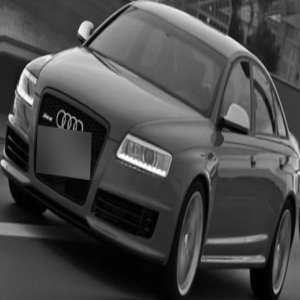

In [ ]:
train_dataset = CarsDataset(root=config.dataset.root,
                                    annotation_file=config.dataset.train_list,
                                    transforms=get_train_aug(config))

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config.dataset.batch_size,
    shuffle=True,
    num_workers=config.dataset.num_workers,
    pin_memory=True,
    drop_last=True
)

piz(train_dataset[7][0])

In [ ]:
def read_image(image_file):
    img = cv2.imread(image_file, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is None:
        raise ValueError('Failed to read {}'.format(image_file))
    # img = Image.fromarray(img.astype('uint8'), 'RGB')
    return img



class CarsDataset(data.Dataset):
    def __init__(self, root, annotation_file, transforms, is_inference=False):
        self.root = root
        self.imlist = pd.read_csv(annotation_file)
        self.transforms = transforms
        self.is_inference = is_inference

    def __getitem__(self, index):
        cv2.setNumThreads(6)
        if self.is_inference:
            impath, x1, y1, x2, y2 = self.imlist.loc[index]
        else:
            impath, x1, y1, x2, y2, target = self.imlist.loc[index]
        full_imname = os.path.join(self.root, impath)

        if not os.path.exists(full_imname):
            print('No file ', full_imname)

        img = read_image(full_imname)

        x1, y1 = int(round(x1)), int(round(y1))
        x2, y2 = int(round(x2)), int(round(y2))

        if 0 <= x1 < x2 and 0 <= y1 < y2 and 0 <= x2 < img.shape[1] and 0 <= y2 < img.shape[0]:
            img = img[y1: y2, x1: x2]

        # img = Image.fromarray(img)
        # print(img)
        img = self.transforms(img)

        if self.is_inference:
            return img
        else:
            return img, target

    def __len__(self):
        return len(self.imlist)

In [ ]:
def get_dataloaders(config):
    """
    Function for creating training and validation dataloaders
    :param config:
    :return:
    """
    print("Preparing train reader...")
    train_dataset = CarsDataset(root=config.dataset.root,
                                        annotation_file=config.dataset.train_list,
                                        transforms=get_train_aug(config))

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.dataset.batch_size,
        shuffle=True,
        num_workers=config.dataset.num_workers,
        pin_memory=True,
        drop_last=True
    )
    print("Done.")

    print("Preparing valid reader...")
    val_dataset = CarsDataset(root=config.dataset.root,
                                      annotation_file=config.dataset.val_list,
                                      transforms=get_val_aug(config))
    valid_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=config.dataset.batch_size,
        shuffle=False,
        num_workers=config.dataset.num_workers,
        drop_last=False,
        pin_memory=True
    )
    print("Done.")
    return train_loader, valid_loader

In [ ]:
val_augs = tv.transforms.Compose([     
            to_pil(),                                
            tv.transforms.Resize(299),
            tv.transforms.CenterCrop(config.dataset.input_size),
            tv.transforms.ToTensor(),
            # normalize
        ])

img = read_image('/content/images/0012f618085e3c8184faee8bd7a020cd.jpg')
img = val_augs(img)
img

## Train Validation

In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

In [ ]:
def train(model: torch.nn.Module,
          train_loader: torch.utils.data.DataLoader,
          criterion: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          config, epoch) -> None:
    """
    Model training function for one epoch
    :param model: model architecture
    :param train_loader: dataloader for batch generation
    :param criterion: selected criterion for calculating the loss function
    :param optimizer: selected optimizer for updating weights
    :param config: train process configuration
    :param epoch (int): epoch number
    :return: None
    """

    model.train()

    loss_stat = AverageMeter('Loss')
    acc_stat = AverageMeter('Acc.')

    train_iter = tqdm(train_loader, desc='Train', dynamic_ncols=True, position=1)

    for step, (x, y) in enumerate(train_iter):
        out = model(x.cuda().to(memory_format=torch.contiguous_format))
        loss = criterion(out, y.cuda())
        num_of_samples = x.shape[0]

        loss_stat.update(loss.detach().cpu().item(), num_of_samples)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scores = torch.softmax(out, dim=1).detach().cpu().numpy()
        predict = np.argmax(scores, axis=1)
        gt = y.detach().cpu().numpy()

        acc = np.mean(gt == predict)
        acc_stat.update(acc, num_of_samples)

        if step % config.train.freq_vis == 0 and not step == 0:
            acc_val, acc_avg = acc_stat()
            loss_val, loss_avg = loss_stat()
            print('Epoch: {}; step: {}; loss: {:.4f}; acc: {:.2f}; lr: {}'.format(epoch, step, loss_avg, acc_avg, optimizer.state_dict()['param_groups'][-1]['lr']))
            
    acc_val, acc_avg = acc_stat()
    loss_val, loss_avg = loss_stat()
    print('Train process of epoch: {} is done; \n loss: {:.4f}; acc: {:.2f}'.format(epoch, loss_avg, acc_avg))

    metrics = {"train_loss": loss_avg, 
               "train_accuracy": acc_avg,
               "learning_rate": optimizer.state_dict()['param_groups'][-1]['lr']}
    # 🐝 Log train metrics to wandb 
    wandb.log(metrics)

In [ ]:
def validation(model: torch.nn.Module,
               val_loader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module,
               epoch) -> None:
    """
    Model validation function for one epoch
    :param model: model architecture
    :param val_loader: dataloader for batch generation
    :param criterion: selected criterion for calculating the loss function
    :param epoch (int): epoch number
    :return: float: avg acc
     """
    loss_stat = AverageMeter('Loss')
    acc_stat = AverageMeter('Acc.')

    with torch.no_grad():
        model.eval()
        val_iter = tqdm(val_loader, desc='Val', dynamic_ncols=True, position=2)

        for step, (x, y) in enumerate(val_iter):
            out = model(x.cuda().to(memory_format=torch.contiguous_format))
            loss = criterion(out, y.cuda())
            num_of_samples = x.shape[0]

            loss_stat.update(loss.detach().cpu().item(), num_of_samples)

            scores = torch.softmax(out, dim=1).detach().cpu().numpy()
            predict = np.argmax(scores, axis=1)
            gt = y.detach().cpu().numpy()

            acc = np.mean(gt == predict)
            acc_stat.update(acc, num_of_samples)

        acc_val, acc_avg = acc_stat()
        loss_val, loss_avg = loss_stat()
        print('Validation of epoch: {} is done; \n loss: {:.4f}; acc: {:.2f}'.format(epoch, loss_avg, acc_avg))

        metrics = {"val_loss": loss_avg, 
                  "val_accuracy": acc_avg,
                   "epoch": epoch}
        # 🐝 Log train metrics to wandb 
        wandb.log(metrics)

        return acc_avg, loss_avg

## Main

In [ ]:
with open('/content/MCS2022.Baseline-main/config/baseline_mcs.yml') as f:
    data = yaml.safe_load(f)

config = convert_dict_to_tuple(data)
seed = config.dataset.seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
outdir = osp.join(config.outdir, config.exp_name)

print("Savedir: {}".format(outdir))

Savedir: experiments/baseline_mcs


Training

In [ ]:
wandb.init(
      # Set the project where this run will be logged
      project="car_verification", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"experiment_{config.model.arch}", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": config.train.learning_rate,
      "optimizer": config.train.optimizer,
      "lr_schedule": config.train.lr_schedule,
      "n_epochs": config.train.n_epoch,
      })

if not os.path.exists(outdir):
    os.makedirs(outdir)
train_loader, val_loader = get_dataloaders(config)

print("Loading model...")

net = load_model(config)
# net.load_state_dict(torch.load('/content/drive/MyDrive/Olimpiads/Machines_Can_See/models/efficientnetv2_s_new_classes.ckpt'))
net.cuda()

if config.num_gpu > 1:
    net = torch.nn.DataParallel(net)

print("Done.")

criterion, optimizer, scheduler = get_training_parameters(config, net, len(train_loader))
train_epoch = tqdm(range(config.train.n_epoch), dynamic_ncols=True, desc='Epochs', position=0)

# main process
best_acc = 0.0

wandb: Currently logged in as: kartasar. Use `wandb login --relogin` to force relogin


Preparing train reader...
Done.
Preparing valid reader...
Done.
Loading model...


No pretrained weights exist for this model. Using random initialization.


Done.
Opt:  SGD


Epochs:   0%|          | 0/90 [00:00<?, ?it/s]

In [ ]:
net.cuda()
for epoch in train_epoch:
    if epoch in list(range(0, 23)): 
        continue
    train(net, train_loader, criterion, optimizer, config, epoch)
    torch.save(net.state_dict(), f'/content/drive/MyDrive/Olimpiads/Machines_Can_See/models/{config.model.arch}_new_classes.ckpt')
    epoch_avg_acc, epoch_loss_avg = validation(net, val_loader, criterion, epoch)
    if epoch_avg_acc >= best_acc:
        save_checkpoint(net, optimizer, scheduler, epoch, outdir)
        best_acc = epoch_avg_acc
    if config.train.lr_schedule.name == 'ReduceLROnPlateau': 
        scheduler.step(epoch_loss_avg)
    elif config.train.lr_schedule.name == 'StepLR': 
        scheduler.step()

wandb.summary['best_acc'] = best_acc
# 🐝 Close your wandb run 
wandb.finish() # loss: 0.1475; acc: 0.96

In [ ]:
torch.save(net.state_dict(), '/content/drive/MyDrive/Olimpiads/Machines_Can_See/effnetb3.ckpt')

Submission

In [ ]:
import argparse
import os
import sys
import yaml
from collections import OrderedDict

from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torchvision.models as models
from sklearn.preprocessing import normalize
import pickle
# import pytorch_lightning

In [ ]:
!unzip /content/drive/MyDrive/Olimpiads/Machines_Can_See/public_test.zip

In [ ]:
net = load_model(config)
net.load_state_dict(torch.load('/content/drive/MyDrive/Olimpiads/Machines_Can_See/efficientnetv2_s.ckpt'))
model = net

In [ ]:
from sklearn.preprocessing import normalize

class mini_config():
    def __init__(self, exp_cfg, checkpoint_path, inference_cfg):
        self.exp_cfg = exp_cfg
        self.checkpoint_path = checkpoint_path
        self.inference_cfg = inference_cfg

args = mini_config('/content/MCS2022.Baseline-main/config/baseline_mcs.yml', 
               '/content/drive/MyDrive/Olimpiads/Machines_Can_See/efficientnetv2_s.ckpt', 
               '/content/MCS2022.Baseline-main/config/inference_config.yml')

with open(args.exp_cfg) as f:
    data = yaml.safe_load(f)

exp_cfg = convert_dict_to_tuple(data)

with open(args.inference_cfg) as f:
    data = yaml.safe_load(f)

inference_cfg = convert_dict_to_tuple(data)

# getting model and checkpoint
print('Creating model and loading checkpoint')

'''
model = pretrainedmodels.se_resnext101_32x4d() # __dict__[exp_cfg.model.arch]() # model = models.__dict__[exp_cfg.model.arch](num_classes=exp_cfg.dataset.num_of_classes)
checkpoint = torch.load(args.checkpoint_path, map_location='cuda') # ['state_dict']

new_state_dict = OrderedDict()

for k, v in checkpoint.items():
    name = k.replace("module.", "")
    new_state_dict[name] = v


model.load_state_dict(checkpoint)
# model.fc = torch.nn.Identity()
'''

model.classifier = nn.Identity()
model.eval()
model.cuda()

print('Weights are loaded, fc layer is deleted')

test_dataset = CarsDataset(root=inference_cfg.root,
                    annotation_file=inference_cfg.test_list,
                    transforms=get_val_aug(exp_cfg),
                    is_inference=True)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=inference_cfg.batch_size,
        shuffle=False,
        pin_memory=True)

print('Calculating embeddings')

with torch.no_grad():
    for i, images in tqdm(enumerate(test_loader, 0), total=len(test_loader)):
        images = images.to('cuda')
        outputs = model(images)
        outputs = outputs.data.cpu().numpy()
        if i == 0:
            embeddings = outputs
        else:
            embeddings = np.vstack((embeddings, outputs))

print(embeddings.shape)
imgname2idx_dict = dict([x, i] for i, x in enumerate(test_dataset.imlist.img_path))

#normalize and get distances
print('Normalizing and calculating distances')

embeddings = torch.from_numpy(embeddings)

embeddings = normalize(embeddings)

submit_pairs_df = pd.read_csv(inference_cfg.pairs_list)
dist_arr = np.empty(len(submit_pairs_df), dtype=float)

for row in submit_pairs_df.itertuples():
    embedding1 = embeddings[imgname2idx_dict[row.img1]]
    embedding2 = embeddings[imgname2idx_dict[row.img2]]
    dist_arr[row.Index] = np.linalg.norm(embedding1 - embedding2)

submit_pairs_df['dist'] = dist_arr

print('Getting final scores')
submit_pairs_df['score'] = submit_pairs_df.dist.apply(lambda x: (2 - x)/2)

exp_name = exp_cfg.exp_name
model_epoch = os.path.basename(args.checkpoint_path).replace('.pth', '')
save_path = f'./{exp_name}_{model_epoch}.csv'
submit_pairs_df[['id', 'score']].to_csv(save_path, index=False)

print(f'Congrats! You have created submission. {save_path}')